<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 7: Data Augmentation and ViT

</div>

Converting a convolutional neural network (CNN) architecture into a Vision Transformer (ViT) involves fundamentally changing the way the network processes images. A CNN uses filters to process spatial hierarchies, while a ViT treats an image as a sequence of patches and processes them using a transformer architecture, which is the same type of architecture used in NLP tasks.

To create a ViT model, you can follow this general outline:

1. Split the image into fixed-size patches.
2. Flatten the patches and map to a higher-dimensional space (if needed).
3. Add positional embeddings to the flattened patches.
4. Use a series of transformer blocks which contain multi-head self-attention and MLPs (multi-layer perceptrons).
5. Use a classification head at the end of the transformer blocks to make predictions.

In [1]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-11-05 19:56:45--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   278MB/s    in 0.2s    

2023-11-05 19:56:46 (278 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-11-05 19:56:46--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## A. Data Loading and Preprocessing

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.auto import tqdm
import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0).astype(np.uint8)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0).astype(np.int32)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0).astype(np.uint8)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0).astype(np.int32)

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)


### Data Augmentation in PyTorch

Data augmentation is a strategy to significantly increase the diversity of data available for training models without actually collecting new data. It is particularly useful in scenarios like medical image processing where the dataset sizes are often limited.

#### PyTorch Transforms

In PyTorch, the `torchvision.transforms` module provides a suite of tools for data augmentation which can be composed in a pipeline. More details and a full list of available transforms can be found in the [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html).


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

class MedicalDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.transform(Image.fromarray(self.x[idx])), self.y[idx]

In [4]:
batch_size = 32

train_dataset = MedicalDataset(x_train, y_train, train_transforms)
val_dataset = MedicalDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

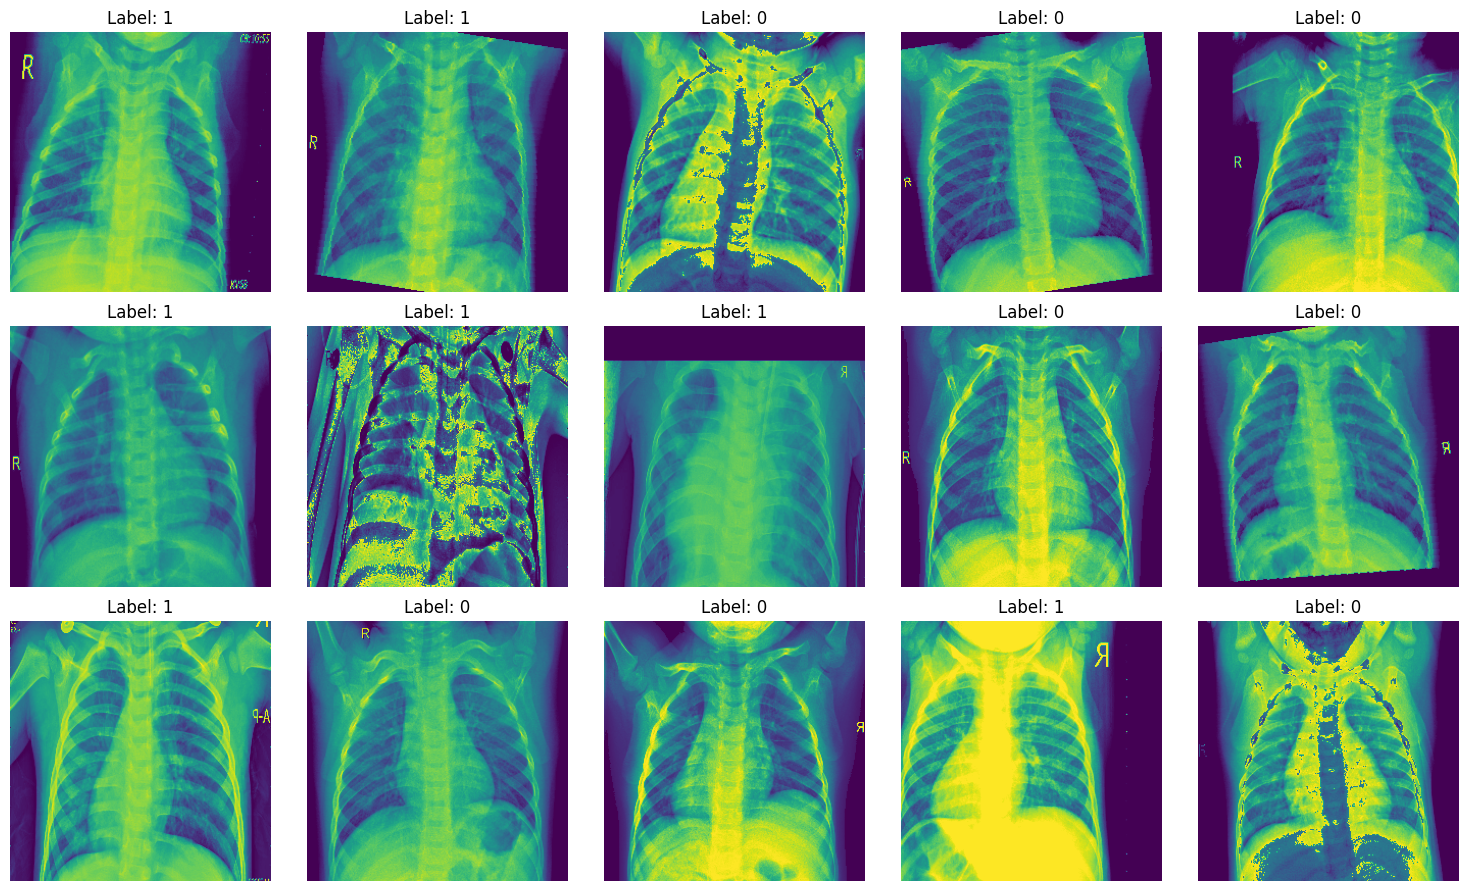

In [5]:
import matplotlib.pyplot as plt
import random

# Define the grid size
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Select random indices
random_indices = random.sample(range(len(train_dataset)), rows * cols)

for idx, ax in zip(random_indices, axes):
    image, label = train_dataset[idx]
    # Assumes the image tensor is in the format CxHxW and needs to be transposed to HxWxC
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## B. Defining Neural Networks

#### 1. **Tokenizer**, which takes an image and splits into several non-overlapping patches.

In [6]:
try:
    import einops
except:
    !pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 811.8 kB/s eta 0:00:00


In [7]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


class Image2Tokens(nn.Module):
    def __init__(self, image_size, dim, in_dim=3, patch_size=16, emb_dropout=0.):
        super().__init__()
        image_height, image_width = image_size
        num_patches = (image_height // patch_size) * (image_width // patch_size)
        patch_dim = in_dim * patch_size * patch_size
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, dim),
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        return self.dropout(x)

#### 2. **Multi-Head Self-Attention**. Implement the following equation: $Softmax(\frac{QK^T}{\sqrt{d}})V$, where Q, K, V are embedded representations of input, $Q=w_Qx, K=w_Kx, V=w_Vx$, in multi-head manner.

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, dim*3)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = (q @ k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

#### 3. **FeedForwardNetwork (FFN)**. Implement $FFN=w_2 GELU(w_1x + b_1) + b_2$.

In [9]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

#### 4. Implement the **transformer encoder**, using prenorm shortcut style.

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class Transformer(nn.Module):
    def __init__(self, layers, dim, heads=8, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(layers):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dropout=dropout)),
                PreNorm(dim, FeedForwardNetwork(dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

#### 5. Package the **ViT model** with hyper-parameters configurable: (i) number of layers; (ii) hidden size; (iii) number of multiheads; (iv) image size (for tokenizer); (v) classifier

In [11]:
class ViT(nn.Module):
    def __init__(self, layers, dim, heads, image_size, num_classes, patch_size=16, in_dim=3, dropout=0., emb_dropout=0.):
        super().__init__()
        self.tokenizer = Image2Tokens(image_size=image_size, dim=dim, in_dim=in_dim, patch_size=patch_size, emb_dropout=emb_dropout)
        self.transformer = Transformer(layers=layers, dim=dim, heads=heads, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        out = self.tokenizer(img)
        out = self.transformer(out)
        out = out[:, 0]
        return self.classifier(out)

## C. Training the Neural Network

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50

model = ViT(in_dim=1, layers=9, dim=192, heads=12, image_size=(256, 256), num_classes=2)
model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 0.8181, Train acc: 50.50%, Val loss: 0.7076, Val acc: 50.00%, Best Val loss: 0.7076 Best Val acc: 50.00%
Epoch 2/50, Train loss: 0.7007, Train acc: 49.38%, Val loss: 0.7145, Val acc: 50.00%, Best Val loss: 0.7076 Best Val acc: 50.00%
Epoch 3/50, Train loss: 0.6794, Train acc: 56.31%, Val loss: 0.5519, Val acc: 76.25%, Best Val loss: 0.5519 Best Val acc: 76.25%
Epoch 4/50, Train loss: 0.6461, Train acc: 60.88%, Val loss: 0.4682, Val acc: 80.75%, Best Val loss: 0.4682 Best Val acc: 80.75%
Epoch 5/50, Train loss: 0.6114, Train acc: 66.38%, Val loss: 0.4533, Val acc: 82.25%, Best Val loss: 0.4533 Best Val acc: 82.25%
Epoch 6/50, Train loss: 0.5725, Train acc: 69.38%, Val loss: 0.4289, Val acc: 81.50%, Best Val loss: 0.4289 Best Val acc: 82.25%
Epoch 7/50, Train loss: 0.5889, Train acc: 67.88%, Val loss: 0.5283, Val acc: 78.25%, Best Val loss: 0.4289 Best Val acc: 82.25%
Epoch 8/50, Train loss: 0.5719, Train acc: 70.25%, Val loss: 0.4845, Val acc: 76.00%, Best Val lo

### Visualizing model performance

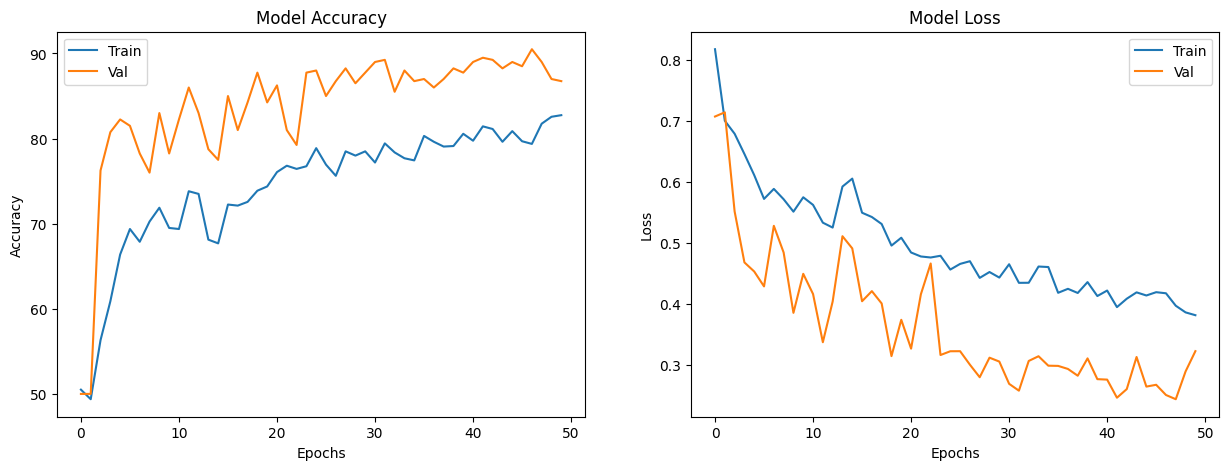

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [14]:
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-11-05 20:05:07--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107328 (12M) [application/octet-stream]
Saving to: ‘test_normal.npy’

test_normal.npy     100%[===================>]  12.50M  --.-KB/s    in 0.03s   

2023-11-05 20:05:07 (446 MB/s) - ‘test_normal.npy’ saved [13107328/13107328]

--2023-11-05 20:05:07--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respons

In [15]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0).astype(np.uint8)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0).astype(np.int32)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [16]:
batch_size = 1
test_dataset = MedicalDataset(x_test, y_test, val_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

In [17]:
model = ViT(in_dim=1, layers=9, dim=192, heads=12, image_size=(256, 256), num_classes=2)
model.load_state_dict(torch.load('model_classification.pth'))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        outputs = model(images)

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

  0%|          | 0/400 [00:00<?, ?it/s]

Test accuracy is 77.25%


### (Extra) Visual inspect the learned attention weights

In [18]:
from functools import wraps
import torch
from torch import nn

def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

class Recorder(nn.Module):
    def __init__(self, vit, device = None):
        super().__init__()
        self.vit = vit

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

    def _register_hook(self):
        modules = find_modules(self.vit.transformer, Attention)
        for module in modules:
            handle = module.attend.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.vit

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()
        if not self.hook_registered:
            self._register_hook()

        pred = self.vit(img)

        # move all recordings to one device before stacking
        target_device = self.device if self.device is not None else img.device
        recordings = tuple(map(lambda t: t.to(target_device), self.recordings))

        attns = torch.stack(recordings, dim = 1) if len(recordings) > 0 else None
        return pred, attns

In [19]:
model.load_state_dict(torch.load('model_classification.pth'))

<All keys matched successfully>

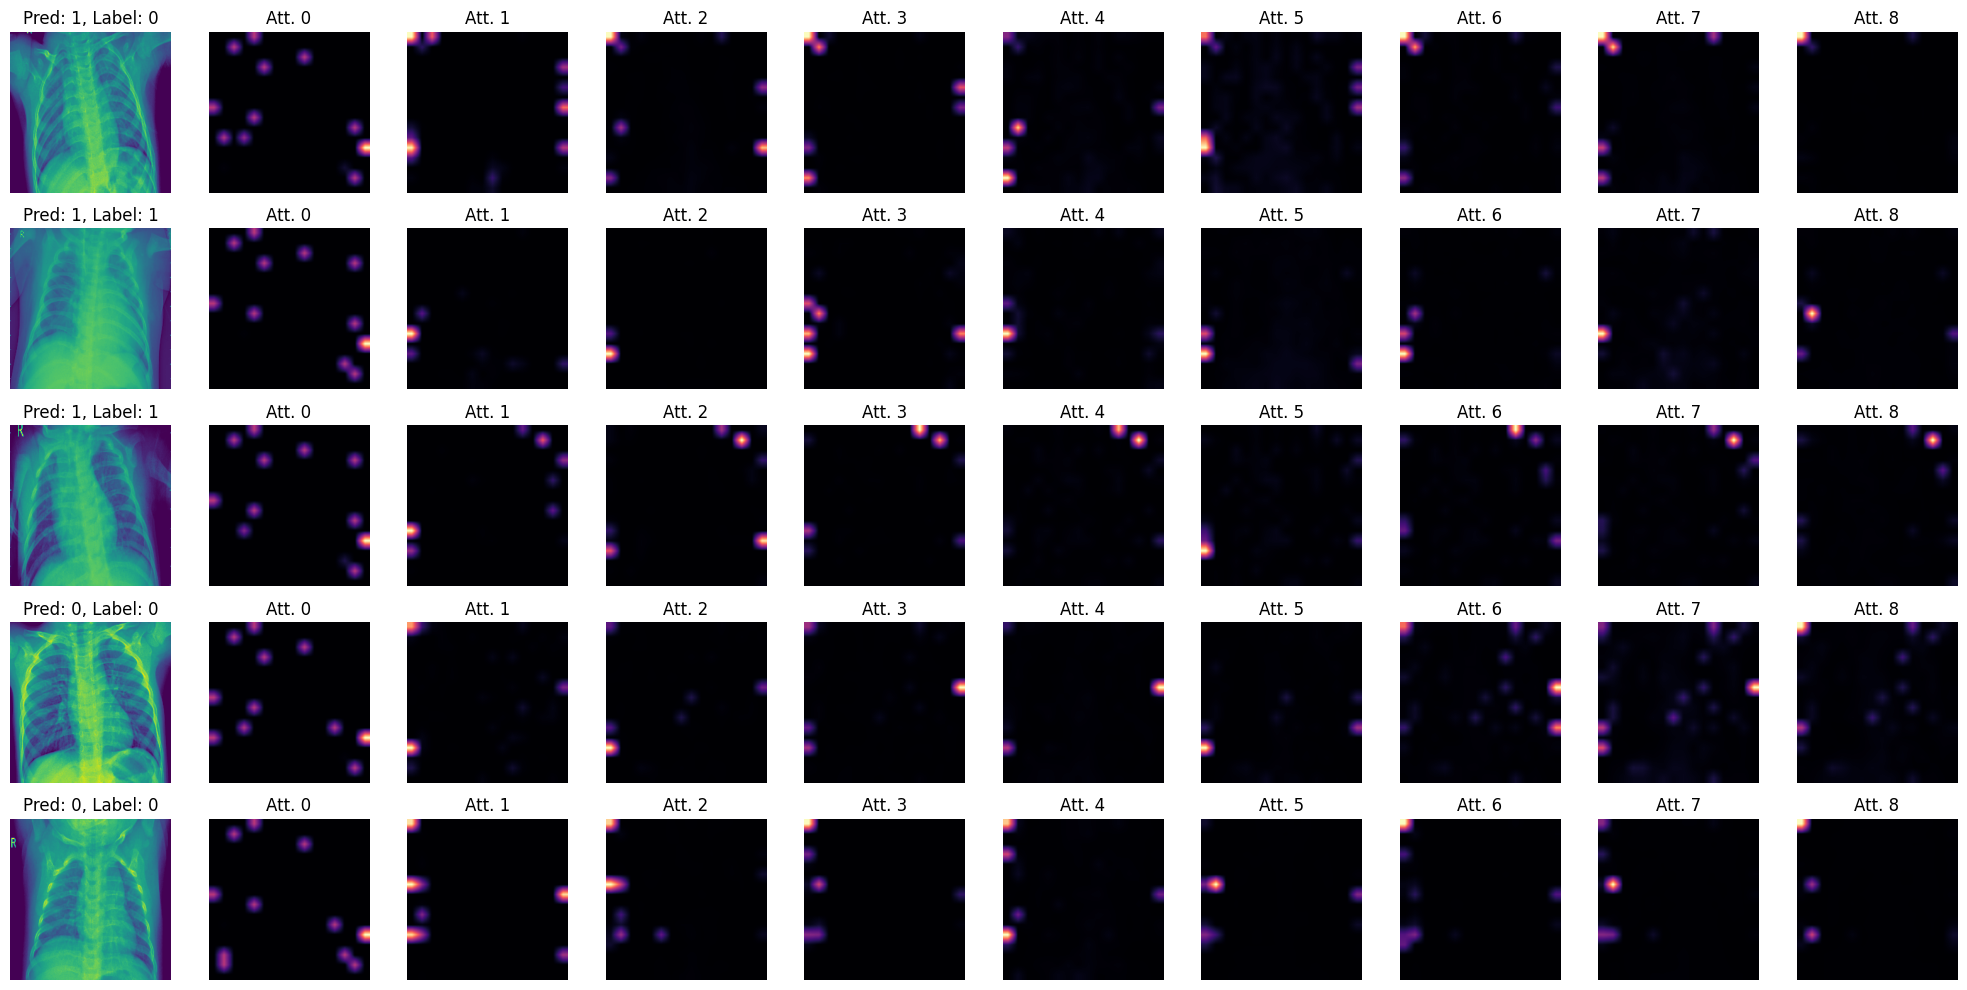

In [24]:
import cv2
import matplotlib.pyplot as plt

patch_size = 16
image_size = 256

# Number of random samples to visualize
num_samples = 5
num_attn_maps = 9  # number of attention maps you want to display for each sample

# Select random samples from the validation loader
random_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# Setup the model
model.cpu()
model.eval()
v = Recorder(model)

fig, axes = plt.subplots(num_samples, num_attn_maps + 1, figsize=(20, 2 * num_samples))

for row, idx in enumerate(random_indices):
    data, label = test_dataset[idx]
    data = data.unsqueeze(0)  # Add batch dimension
    pred, attns = v(data)

    # Original image
    axes[row, 0].imshow(data[0].permute(1, 2, 0).numpy())
    axes[row, 0].axis('off')
    axes[row, 0].set_title(f'Pred: {pred[0].argmax().item()}, Label: {label}')

    # Attention maps
    m = attns[0][:, :, 0, 1:].sum(1)
    for attn_map_idx, ax in enumerate(axes[row, 1:]):
        if attn_map_idx < num_attn_maps:
            attention_map = cv2.resize(m[attn_map_idx].reshape(image_size // patch_size, image_size // patch_size).numpy(), (image_size, image_size))
            ax.imshow(attention_map, cmap='magma')
            ax.axis('off')
            ax.set_title(f'Att. {attn_map_idx}')
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()